        6ta Escuela Uniandina de Detectores de Partículas-2023.
                    Universidad de los Andes
                        Depto de Física

    Taller Hands-On #2: Particle Physics Simulation - MG/PYTHIA/DELPHES.
        Autores: Cristian Rodríguez PhD(c), Andrés Florez PhD, Carlos Ávila PhD.
        
                            03/10/2023

In [1]:
import hep_pheno_tools

Welcome to JupyROOT 6.22/06


In [2]:
from tqdm.notebook import tqdm
from hep_pheno_tools.delphes_reader.loader import DelphesLoader

# leptons are electrons and muons in a unique list
from hep_pheno_tools.delphes_reader.classifier import get_good_leptons

# jets come in three ways: light jets, b-jets and tau-jets in a dict
from hep_pheno_tools.delphes_reader.classifier import get_good_jets

from hep_pheno_tools.analysis_tools import Quiet
from ROOT import TChain

n_files = 2


signal = 'z_jets'
with Quiet():
    reader = DelphesLoader(
        signal, 
        )
    root_files=reader.Forest[:n_files] # take the first 5 files
    n_events = reader.get_nevents(root_files)
    print(f'Estamos cargando:{n_events} eventos')
    print(f'Desde {len(root_files)} archivos de root')
    tree = TChain("Delphes;1")

    for root_file in root_files:
        tree.Add(root_file)
    m_results = {}
    dict_counters = {}
    for event in tqdm(tree, total=reader.get_nevents(root_files)):
        
        dict_counters['total'] = dict_counters.get('total', 0) + 1

        # get this particles from the event
        leptons = get_good_leptons(event)
        jets = get_good_jets(event)['l_jet']
        bjets = get_good_jets(event)['b_jet']

        # Classify the event
        if (len(jets) >= 2) and (len(leptons) == 0) and (len(bjets) == 0):
            part_1 = jets[0] # 0 is the leading jet
            part_2 = jets[1] # 1 is the subleading jet
            case = 'jj'
        elif (len(jets) == 0) and (len(leptons) >= 2 ) and (len(bjets) == 0):
            part_1 = leptons[0] # 0 is the leading lepton
            part_2 = leptons[1] # 1 is the subleading lepton
            case = 'll'
        elif (len(jets) == 0) and (len(leptons) == 0 ) and (len(bjets) >= 2):
            part_1 = bjets[0] # 0 is the leading bjet
            part_2 = bjets[1] # 1 is the subleading bjet
            case = 'bb'
        else :
            continue
        
        # reconstruct the Z boson

        reco_z_tlv = part_1.tlv + part_2.tlv
        m = reco_z_tlv.M()
        # ADD a simple cut on m
        if not(60 < m < 120): 
            continue
        cut = 'm_cut'
        counters = dict_counters.get(case, {})
        counters[cut] = counters.get(cut, 0) + 1
        dict_counters[case] = counters

        # ADD a cut on deltaR: hint part_1.deltaR(part_2) > 3.0

        
        # ADD a cut on charge for leptons: hint q1 = part_1.charge

        
        # save reconstructed mass in a dict with the case as key
        distribution = m_results.get(case, [])
        distribution.append(m)
        m_results[case] = distribution

z_jets imported with 500 trees!
/Madgraph_Simulations/SM_Backgrounds/z_jets/
Estamos cargando:80079 eventos
Desde 2 archivos de root


  0%|          | 0/80079 [00:00<?, ?it/s]

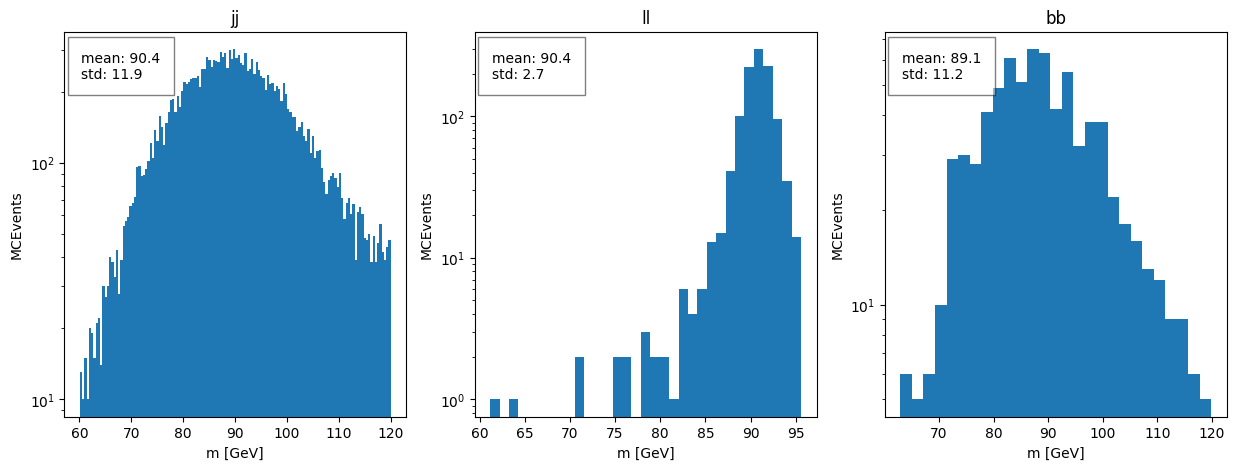

In [3]:
import matplotlib.pyplot as plt
import numpy as np
# create len(mT_results) subplots and unpack the axes array immediately
fig, axs = plt.subplots(1, len(m_results), figsize=(15, 5))
for ax, case in zip(axs, m_results):
    # Fill the histogram
    ax.hist(m_results[case], bins=int(np.sqrt(len(m_results[case]))))
    # add a frame with main stats
    ax.text(
        0.05, 0.95,
        f'mean: {np.mean(m_results[case]):.1f}\nstd: {np.std(m_results[case]):.1f}',
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes,
        bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10}
    )
    ax.set_title(case)
    ax.set_xlabel('m [GeV]')
    ax.set_ylabel('MCEvents')
    # set log scale
    ax.set_yscale('log')
plt.show()


In [4]:
import pandas as pd
efficiency_df = pd.DataFrame(
    index=['efficiency', 'uncertainty', 'relative uncertainty (%)']
    )
for case in m_results:
    # get the efficiency
    efficiency = len(m_results[case])/n_events
    eff_err = np.sqrt(efficiency*(1-efficiency)/n_events)
    efficiency_df[case] = [efficiency, eff_err, eff_err*100/efficiency]
efficiency_df

,jj,ll,bb
efficiency,0.238115,0.013662,0.009478
uncertainty,0.001505,0.000410,0.000342
relative uncertainty (%),0.632109,3.002647,3.612527


# Ejercicio
- Añade los cortes solicitados y vuelve a imprimir el histograma.
- Evalúa la eficiencia absoluta de cada corte.